In [123]:
# --- Core ---
import os, copy, math, numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- MONAI ---
from monai.data import Dataset, DataLoader, decollate_batch
from monai.utils import set_determinism
from monai.config import print_config
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, EnsureType,
    Orientationd, Spacingd, ScaleIntensityRanged, ResizeWithPadOrCropd, Resized,
    RandFlipd, RandRotate90d, RandAffined, RandGaussianNoised, RandRotated,
    RandBiasFieldd, RandGibbsNoised, RandAdjustContrastd,
    Invertd, Activationsd, AsDiscreted
)
from monai.inferers import sliding_window_inference

# --- Torch / model dummy ---
import torch
from monai.networks.nets import UNet   # modelo dummy solo para la demo

In [124]:
import numpy as np

arr = np.array([[1, 2], [3, 4], [5, 6]])
print("Original array:\n", arr)

# Incorrect usage: result is not assigned
np.swapaxes(arr, 0, 1)
print("Array after incorrect swapaxes call:\n", arr.shape) # Will be unchanged

# Correct usage: assign the result
swapped_arr = np.swapaxes(arr, 0, 1)
print("Array after correct swapaxes call:\n", swapped_arr.shape)

Original array:
 [[1 2]
 [3 4]
 [5 6]]
Array after incorrect swapaxes call:
 (3, 2)
Array after correct swapaxes call:
 (2, 3)


In [162]:
def show_triptych(img3d, mask3d=None, pred3d=None, axis="z",ax = None, idx=None, title=None):
    """
    Visualiza un 'slice' de una imagen 3D con máscara GT y predicción superpuestas.
    - img3d: numpy (D,H,W) o (H,W,D) según axis; este helper se encarga.
    - mask3d/pred3d: numpy int con valores {0,1,2} (o {0,1}).
    """
    assert axis in ("z", "y", "x")
    # Reordenar a (D,H,W) para indexar siempre por 'z'
    if img3d.ndim == 3:
        if axis == "z":
            vol = img3d
            msk = mask3d if mask3d is None else mask3d
            prd = pred3d if pred3d is None else pred3d
        elif axis == "y":
            #print("swap y")
            vol = np.swapaxes(img3d, 0, 1)  # (H,D,W)
            #vol = np.swapaxes(vol, 0, 1)    # (D,H,W)
            msk = None if mask3d is None else np.swapaxes(mask3d,0,1)
            prd = None if pred3d is None else np.swapaxes(pred3d,0,1)
        else:  # axis == "x"
            #print("swap x")
            vol = np.swapaxes(img3d, 0, 2)  # (W,H,D)
            #vol = np.swapaxes(vol, 0, 2)    # (D,H,W)
            msk = None if mask3d is None else np.swapaxes(mask3d,0,2)
            prd = None if pred3d is None else np.swapaxes(pred3d,0,2)
    else:
        raise ValueError("img3d debe ser 3D")

    D = vol.shape[0]
    if idx is None:
        # si hay máscara, elegir el slice con mayor área de máscara; sino el central
        if msk is not None:
            areas = [np.count_nonzero(msk[z] > 0) for z in range(D)]
            idx = int(np.argmax(areas))
        else:
            idx = D // 2

    img = vol[idx]
    #fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.imshow(img, cmap="gray")
    if msk is not None:
        # colores: 1->amarillo, 2->cian
        overlay = np.zeros((*msk[idx].shape, 3), dtype=float)
        overlay[msk[idx]==1] = [1.0, 1.0, 0.0]
        overlay[msk[idx]==2] = [0.0, 1.0, 1.0]
        ax.imshow(overlay, alpha=0.35)
    if prd is not None:
        border = (prd[idx]>0).astype(float) - (msk[idx]>0).astype(float) if msk is not None else (prd[idx]>0).astype(float)
        # contorno en rojo para visualizar diferencia
        ax.contour(prd[idx]>0, levels=[0.5], linewidths=1.0, colors="red")
    ax.set_axis_off()
    ax.set_title(title + f"slice {axis}={idx}")
    #plt.show()
    return idx


In [194]:
SPACING = (1.0, 1.0, 1.0)
SPATIAL_SIZE = (96, 96, 96)
set_determinism(seed=42)  # hazlo False/None si quieres aleatoriedad total

def get_train_transforms(augment=True):
    t = [
        LoadImaged(keys=["image","label"]),
        EnsureChannelFirstd(keys=["image","label"]),
        Orientationd(keys=["image","label"], axcodes="RAS"),
        Spacingd(keys=["image","label"], pixdim=SPACING, mode=("bilinear","nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=15.0, b_min=0.0, b_max=1.0, clip=True),
        Resized(keys=["image","label"], spatial_size=SPATIAL_SIZE),
    ]
    if augment:
        t += [
            # evita flips L/R por lateralidad (asumiendo RAS: eje X ~ L/R)
            #RandFlipd(keys=["image","label"], prob=0.99, spatial_axis=1),  # A/P
            #RandFlipd(keys=["image","label"], prob=0.5, spatial_axis=2),  # S/I
            #RandRotate90d(keys=["image","label"], prob=0.99, max_k=3),
            #RandRotated(
            #    keys=["image","label"], prob=0.99,
            #    #range_x=(0.4, 0.5),
            #    range_y=(0.4, 0.5), 
            #    #range_z=(0.4, 0.5)
            #     mode=("bilinear","nearest"))
            RandAffined(
                keys=["image","label"], prob=0.99,
                rotate_range=(0.05,0.05,0.05),
                translate_range=(20, 20 , 15),
                scale_range=(0.10,0.10,0.10), padding_mode="border",
                mode=("bilinear","nearest"),
            ),
            #RandBiasFieldd(keys=["image"], prob=0.99, coeff_range=(0.0,0.05)),
            #RandGibbsNoised(keys=["image"], prob=0.99, alpha=(0.9,1.0)),
            #RandGaussianNoised(keys=["image"], prob=0.99, std=0.01),
            #RandAdjustContrastd(keys=["image"], prob=0.99, gamma=(0.7,1.5)),
        ]
    t += [EnsureTyped(keys=["image","label"])]  # MetaTensor (requerido para Invertd)
    return Compose(t)

def get_val_transforms():
    return Compose([
        LoadImaged(keys=["image","label"]),
        EnsureChannelFirstd(keys=["image","label"]),
        Orientationd(keys=["image","label"], axcodes="RAS"),
        Spacingd(keys=["image","label"], pixdim=SPACING, mode=("bilinear","nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=15.0, b_min=0.0, b_max=1.0, clip=True),
        Resized(keys=["image","label"], spatial_size=SPATIAL_SIZE),
        EnsureTyped(keys=["image","label"]),
    ])

def get_test_transforms():
    return Compose([
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=SPACING, mode="bilinear"),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=15.0, b_min=0.0, b_max=1.0, clip=True),
        Resized(keys=["image","label"], spatial_size=SPATIAL_SIZE),
        EnsureTyped(keys=["image"]),
    ])


In [195]:
df = pd.read_csv("../results/preprocessed_data/task2/df_train_hipp.csv")
df.head(2)

,filepath_label,filename_label,ID,source_label,filepath
0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001_HF_hipp.nii.gz,LISA_0001,HF_hipp,/data/cristian/projects/med_data/rise-miccai/t...
1,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0005_HF_hipp.nii.gz,LISA_0005,HF_hipp,/data/cristian/projects/med_data/rise-miccai/t...


In [196]:
from torch.utils.data import Dataset
import os
from typing import List, Iterable, Optional
import tqdm

from __future__ import annotations

from torch.utils.data import Dataset
from typing import Optional, Dict, Any
import pandas as pd
import numpy as np
import torch
import os

try:
    import nibabel as nib  # solo usado si transform es None
except ImportError:
    nib = None


class MRIDataset3D(Dataset):
    """
    Minimal 3D MRI dataset that plays nicely with MONAI dict transforms.

    - Expects a DataFrame with column 'filepath' and, if training, 'filepath_label'.
    - If `transform` is provided, it should accept/return a dict with keys
      'image' and (optionally) 'label' (e.g., MONAI's Compose with LoadImaged, etc).
    - If `transform` is None, falls back to nibabel loading and returns torch tensors.

    Returns (by default) a dict with:
        {'image': Tensor [1,D,H,W], 'label': Tensor [1,D,H,W] (if available),
         'image_path': str, 'label_path': Optional[str]}
    """

    def __init__(
        self,
        df: pd.DataFrame,
        is_train: bool = True,
        transform: Optional[callable] = None,
    ) -> None:
        self.df = df.reset_index(drop=True)
        self.is_train = is_train
        self.transform = transform

        self._has_label = self.is_train and ("filepath_label" in self.df.columns)

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        row = self.df.iloc[idx]
        img_path = row["filepath"]
        sample: Dict[str, Any] = {"image": img_path, "image_path": img_path}

        if self._has_label and pd.notna(row.get("filepath_label", None)):
            lab_path = row["filepath_label"]
            sample["label"] = lab_path
            sample["label_path"] = lab_path
        else:
            sample["label_path"] = None

        if self.transform is not None:
            # MONAI-style: transform loads and returns tensors/MetaTensors
            out = self.transform(sample)
            # ensure the meta paths stay available
            out.setdefault("image_path", img_path)
            out.setdefault("label_path", sample.get("label_path", None))
            return out

        # Fallback path: no transform -> direct nibabel load
        img_t = self._fallback_load(img_path)
        out = {"image": img_t, "image_path": img_path}

        if sample["label_path"] is not None:
            lab_t = self._fallback_load_label(sample["label_path"])
            out["label"] = lab_t
            out["label_path"] = sample["label_path"]

        return out


In [204]:
def df_to_list(df, is_test=False):
    data = []
    for _, r in df.iterrows():
        item = {"image": r["filepath"]}
        if not is_test and "filepath_label" in df.columns and pd.notna(r.get("filepath_label", None)):
            item["label"] = r["filepath_label"]
        data.append(item)
    return data

# Ejemplo:
# df = pd.read_csv("df_train.csv")
#train_data = df_to_list(df, is_test=False)
#train_ds = Dataset(train_data, transform=get_train_transforms(augment=True))
#val_ds   = Dataset(train_data, transform=get_val_transforms())  # para demo uso el mismo df

train_ds = MRIDataset3D(df, is_train=True,  transform=get_train_transforms(augment=False))
val_ds   = MRIDataset3D(df, is_train=True,  transform=get_val_transforms())


In [205]:
train_loader = DataLoader(train_ds, batch_size=10, shuffle=False, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=10, shuffle=False, num_workers=2, pin_memory=True)

Train sample 0: /data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz, /data/cristian/projects/med_data/rise-miccai/task-2/960/155887960/LISA_0001_HF_hipp.nii.gz


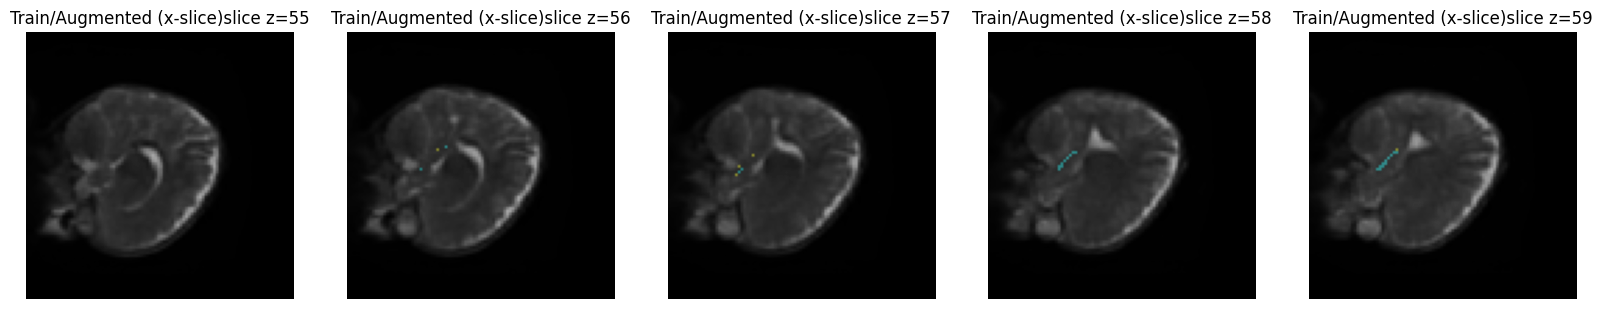

Val sample 0: /data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz, /data/cristian/projects/med_data/rise-miccai/task-2/960/155887960/LISA_0001_HF_hipp.nii.gz


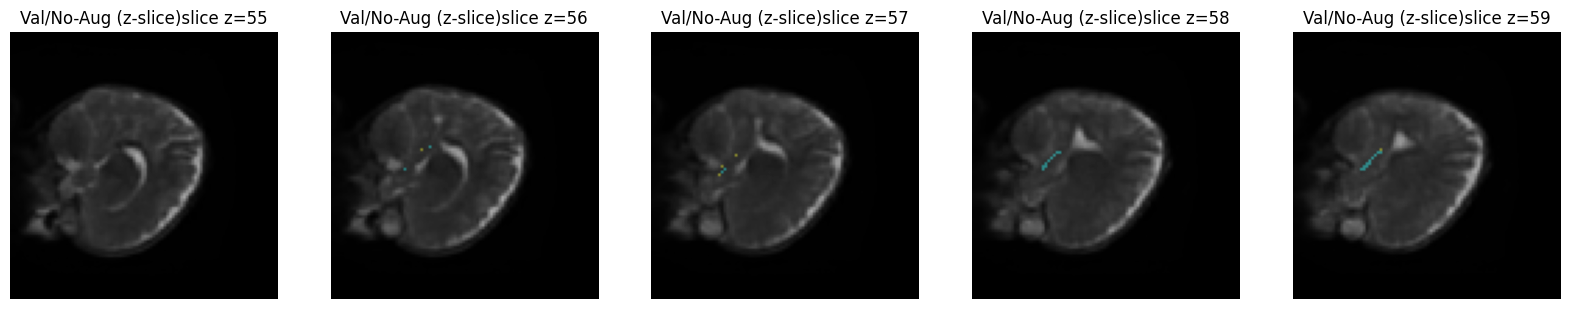

Train sample 1: /data/cristian/projects/med_data/rise-miccai/task-2/704/155885704/LISA_0005_ciso.nii.gz, /data/cristian/projects/med_data/rise-miccai/task-2/963/155887963/LISA_0005_HF_hipp.nii.gz


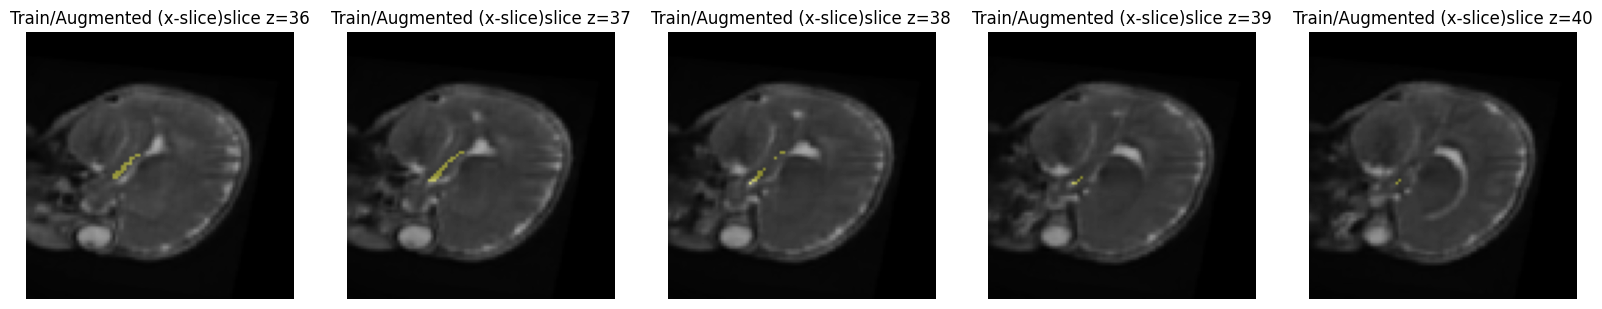

Val sample 1: /data/cristian/projects/med_data/rise-miccai/task-2/704/155885704/LISA_0005_ciso.nii.gz, /data/cristian/projects/med_data/rise-miccai/task-2/963/155887963/LISA_0005_HF_hipp.nii.gz


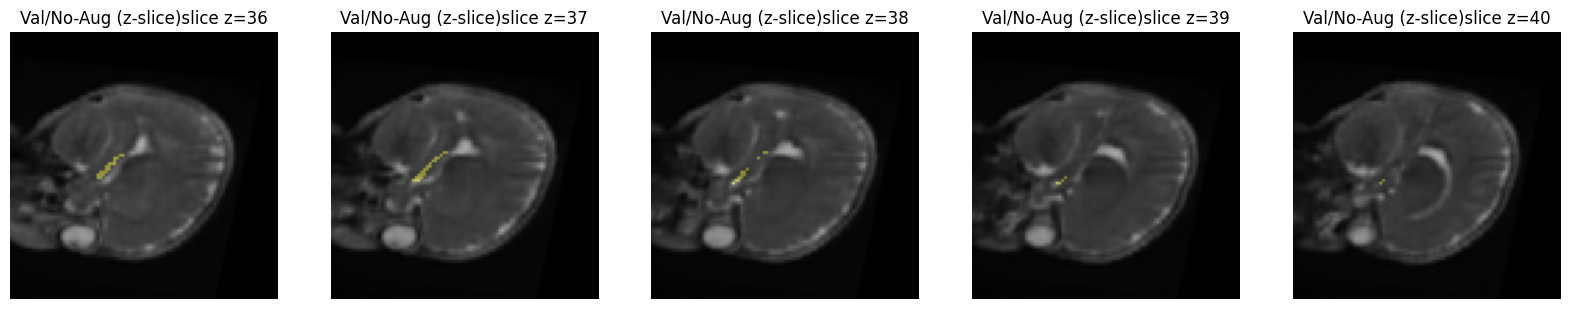

Train sample 2: /data/cristian/projects/med_data/rise-miccai/task-2/709/155885709/LISA_0002_ciso.nii.gz, /data/cristian/projects/med_data/rise-miccai/task-2/962/155887962/LISA_0002_HF_hipp.nii.gz


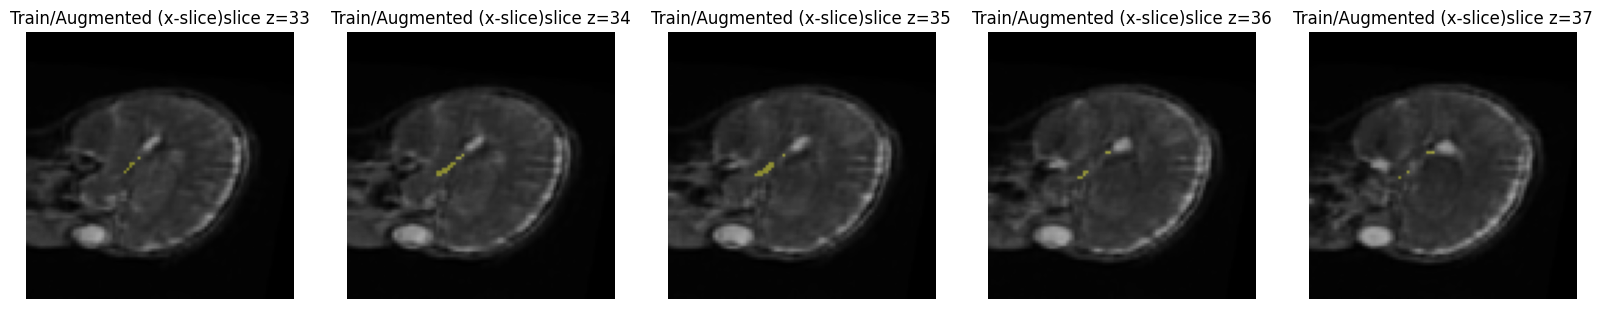

Val sample 2: /data/cristian/projects/med_data/rise-miccai/task-2/709/155885709/LISA_0002_ciso.nii.gz, /data/cristian/projects/med_data/rise-miccai/task-2/962/155887962/LISA_0002_HF_hipp.nii.gz


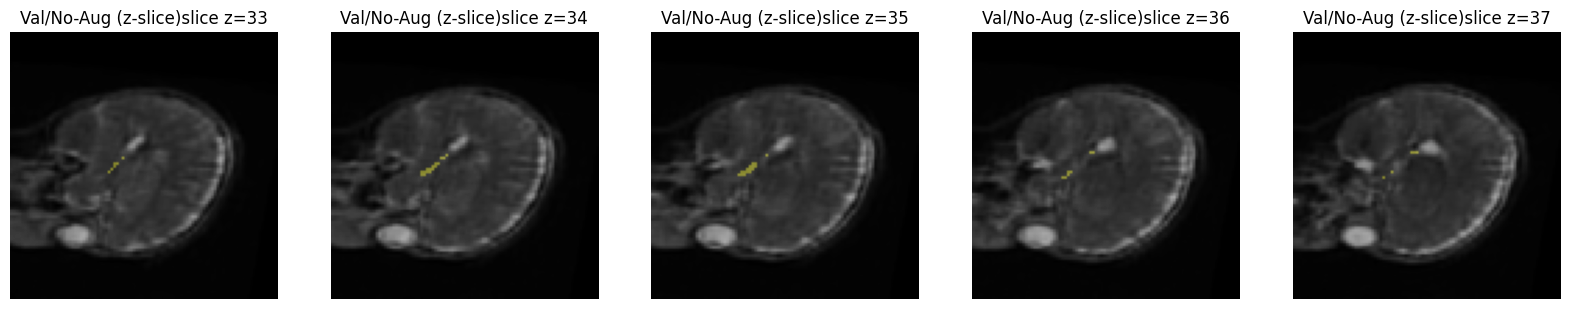

Train sample 3: /data/cristian/projects/med_data/rise-miccai/task-2/738/155885738/LISA_0010_ciso.nii.gz, /data/cristian/projects/med_data/rise-miccai/task-2/966/155887966/LISA_0010_HF_hipp.nii.gz


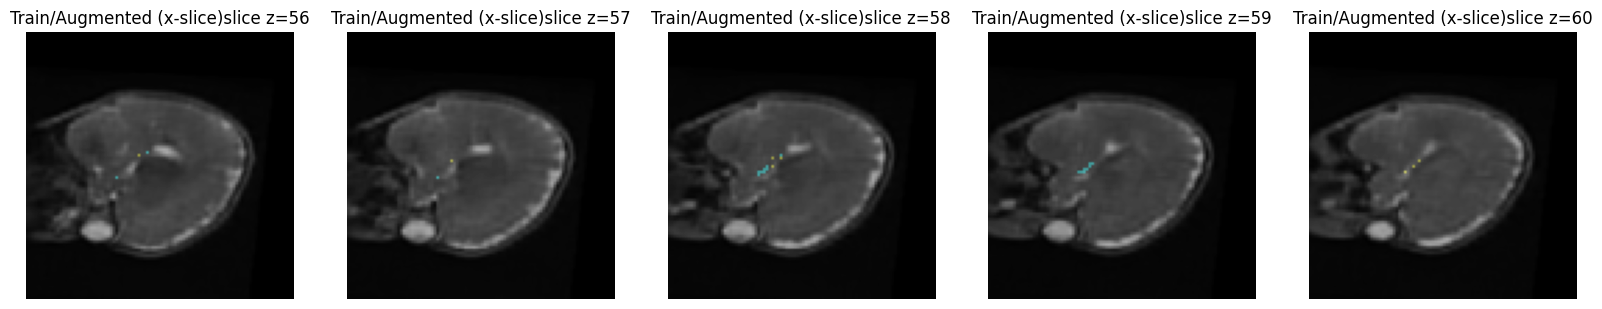

Val sample 3: /data/cristian/projects/med_data/rise-miccai/task-2/738/155885738/LISA_0010_ciso.nii.gz, /data/cristian/projects/med_data/rise-miccai/task-2/966/155887966/LISA_0010_HF_hipp.nii.gz


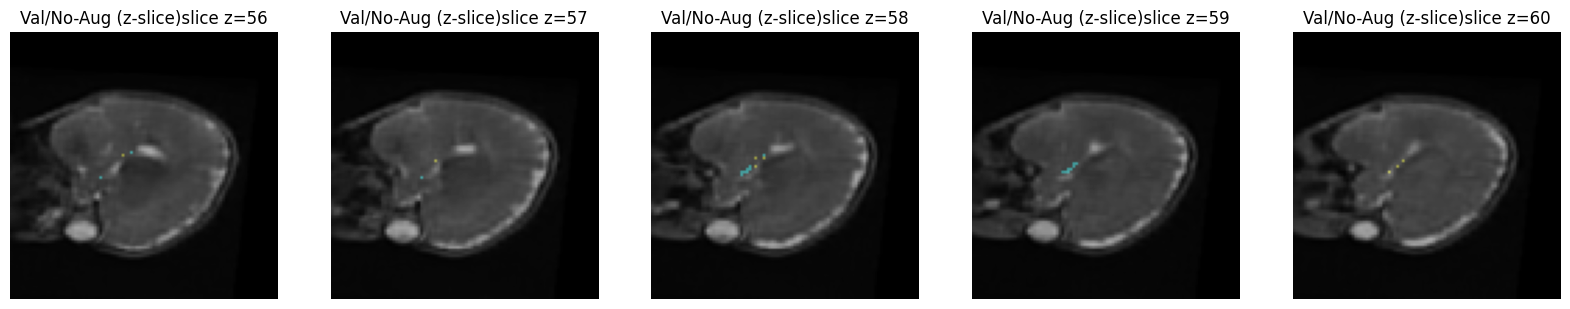

Train sample 4: /data/cristian/projects/med_data/rise-miccai/task-2/734/155885734/LISA_0003_ciso.nii.gz, /data/cristian/projects/med_data/rise-miccai/task-2/961/155887961/LISA_0003_HF_hipp.nii.gz


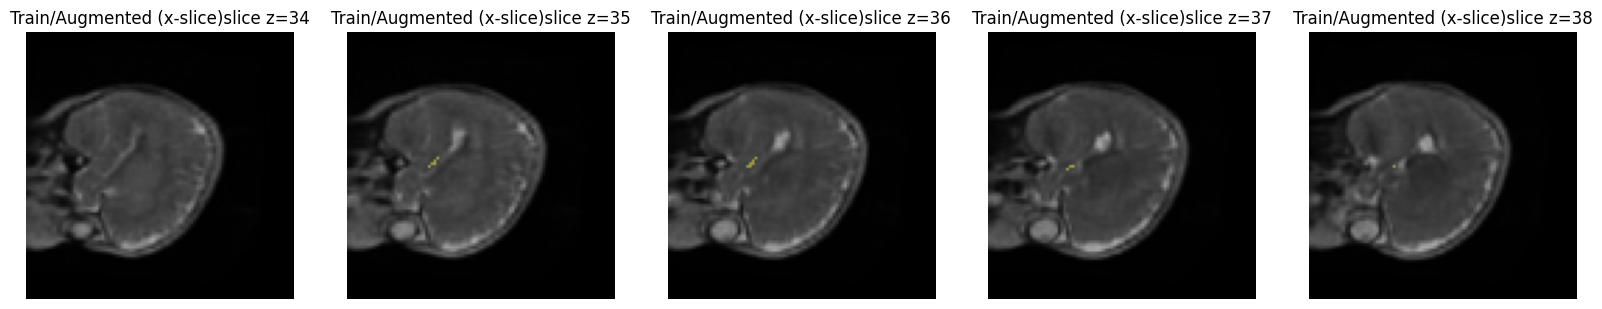

Val sample 4: /data/cristian/projects/med_data/rise-miccai/task-2/734/155885734/LISA_0003_ciso.nii.gz, /data/cristian/projects/med_data/rise-miccai/task-2/961/155887961/LISA_0003_HF_hipp.nii.gz


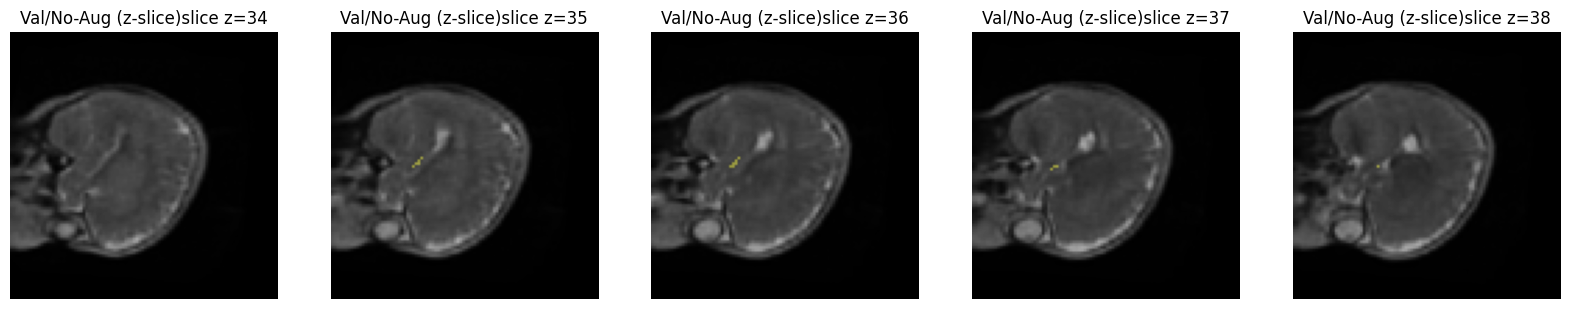

In [206]:
# Visualizar un batch "tal cual" pasa por las transforms
batch = next(iter(train_loader))
batch_val = next(iter(val_loader))
for i in range(5):

  img = batch["image"][i].as_tensor().cpu().numpy()[0]     # (D,H,W)
  lab = batch["label"][i].as_tensor().cpu().numpy()[0]     # (D,H,W)
  img_v = batch_val["image"][i].as_tensor().cpu().numpy()[0]
  lab_v = batch_val["label"][i].as_tensor().cpu().numpy()[0]

  image_path = batch["image_path"][i]
  label_path = batch["label_path"][i]
  print(f"Train sample {i}: {image_path}, {label_path}")
  fig, axes = plt.subplots(1, 5, figsize=(20, 10))
  axes = axes.ravel()
  idx = show_triptych(img_v, mask3d=lab_v, axis="z", title=f"Val/No-Aug (z-slice)", ax=axes[0])
  #idx = show_triptych(img, mask3d=lab, axis="z", title=f"Train/Augmented (x-slice)", ax=axes[0])
  for cnt,idx_ in enumerate(range(idx-2,idx+3)):
    show_triptych(img, mask3d=lab, axis="z", title=f"Train/Augmented (x-slice)", idx=idx_, ax=axes[cnt])
  plt.show()
  image_path = batch_val["image_path"][i]
  label_path = batch_val["label_path"][i]
  print(f"Val sample {i}: {image_path}, {label_path}")
  fig, axes = plt.subplots(1, 5, figsize=(20, 10))
  axes = axes.ravel()
  for cnt,idx_ in enumerate(range(idx-2,idx+3)):
    show_triptych(img_v, mask3d=lab_v, axis="z", title=f"Val/No-Aug (z-slice)",idx=idx_, ax=axes[cnt])
  plt.show()


In [207]:
batch_val["image_path"]

['/data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/704/155885704/LISA_0005_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/709/155885709/LISA_0002_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/738/155885738/LISA_0010_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/734/155885734/LISA_0003_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/736/155885736/LISA_0006_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/714/155885714/LISA_0004_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/717/155885717/LISA_0007_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/720/155885720/LISA_0008_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/737/155885737/LISA_0009_ciso.nii.gz']

In [153]:
img.ndim, img.shape

(3, (96, 96, 96))

In [61]:
img.min(),img.max()

(0.0, 0.9528827)